In [145]:
import pandas as pd
import pandas_profiling
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

In [256]:
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler, RobustScaler,OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
%matplotlib inline

In [147]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [148]:
#Marking from which dataset the data comes and concating them
train['train'] =1
test['train']=0
test['default'] = 2 #creating a column to concate
banking = pd.concat([train,test], ignore_index = True)

In [5]:
banking.profile_report()

In [298]:
# For making future work easier create lists with types of data in columns
target = 'default'
time_cols = ['app_date']
cat_cols = ['education',  'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work',
            'foreign_passport', 'probable_def']
num_cols = ['age', 'decline_app_cnt', 'region_rating',
            'score_bki', 'bki_request_cnt', 'income']
# client id is not needed
banking.drop('client_id', axis=1, inplace=True)

# Time

In [299]:
#need to reform time columns first
banking['app_date'] = pd.to_datetime(banking['app_date'], format='%d%b%Y')
#Need to get all the data possible - will decide what to do later
banking['day'] = banking['app_date'].dt.day
banking['month'] = banking['app_date'].dt.month
banking['year'] = banking['app_date'].dt.year

In [300]:
time_cols_2  = ['day','month','year']
banking.loc[:,time_cols_2].describe()

day         month     year
count  83171.000000  83171.000000  83171.0
mean      15.950055      2.525111   2014.0
std        8.616333      1.088190      0.0
min        1.000000      1.000000   2014.0
25%        9.000000      2.000000   2014.0
50%       16.000000      3.000000   2014.0
75%       23.000000      3.000000   2014.0
max       31.000000      4.000000   2014.0

In [301]:
#The only year present is 2014, so the year is not needed
banking.drop('year', axis = 1, inplace =True)

In [302]:
#As the year is only 2014, it is logical to count days from 1st january 2014
st_jan_2014 = pd.to_datetime('1/1/2014')
banking['delta_t'] = (banking['app_date']-st_jan_2014 ).dt.days

In [303]:
#As I've agglomerated the time data into delta, we dont need other time columns
banking.drop(['day','app_date','month'],axis = 1, inplace = True)

In [305]:
banking

education sex  age car car_type  decline_app_cnt  good_work  score_bki  \
0           SCH   M   62   Y        Y                0          0  -2.008753   
1           SCH   F   59   N        N                0          0  -1.532276   
2           SCH   M   25   Y        N                2          0  -1.408142   
3           SCH   F   53   N        N                0          0  -2.057471   
4           GRD   M   48   N        N                0          1  -1.244723   
...         ...  ..  ...  ..      ...              ...        ...        ...   
83166       UGR   M   35   N        N                0          0  -1.645473   
83167       SCH   F   41   N        N                0          0  -1.198276   
83168       SCH   M   42   Y        Y                0          0  -1.653235   
83169       GRD   F   51   N        N                0          0  -1.259001   
83170       SCH   F   29   N        N                0          1  -1.479334   

       bki_request_cnt  region_rating  home_address  work_address  income  \
0                    1             50             1             2   18000   
1                    3             50             2             3   19000   
2                    1             80             1             2   30000   
3                    2             50             2             3   10000   
4                    1             60             2             3   30000   
...                ...            ...           ...           ...     ...   
83166                4             40             2             3   25000   
83167                3             60             1             1   25000   
83168                3             70             2             3   50000   
83169                4             30             2             3   15000   
83170                3             50             1             3   13000   

       sna  first_time foreign_passport  default  delta_t  
0        4           1                N        0       31  
1        4           1                N        0       70  
2        1           4                Y        0       31  
3        1           3                N        0       22  
4        1           4                Y        0      107  
...    ...         ...              ...      ...      ...  
83166    4           3                N        1       73  
83167    1           3                N        1       11  
83168    4           4                N        1       75  
83169    1           3                N        1       47  
83170    2           3                N        1        3  

[83171 rows x 18 columns]

# Education

In [306]:
#Education is the only column, which has NONEs
banking.isna().sum()

education           342
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
delta_t               0
dtype: int64

In [307]:
#Filling them with the most often value
banking['education'].fillna('SCH', inplace = True)

# Binaries

In [308]:
#It can be seen that people who haven't had default have near to none decline_app_cnt. Lets make a binary parameter, so that if decline_app_cnt 0.1<x<1, it is one, and if not = 0
banking['probable_def'] = banking['decline_app_cnt']
banking['probable_def'] = banking['probable_def'].apply(lambda x: 1 if x>0.1 and x < 0.69 else 0)

In [309]:
#Making binary columns usable for logistic regression-use LabelEncoder
lable_enc = LabelEncoder()
for col in bin_cols:
    banking[col] = lable_enc.fit_transform(banking[col])

In [310]:
#car and car_times do strongly correlate so we can drop car_type

In [311]:
banking.drop('car_type', axis = 1, inplace = True)

In [312]:
bin_cols = ['sex', 'car', 'good_work',
            'foreign_passport', 'probable_def']

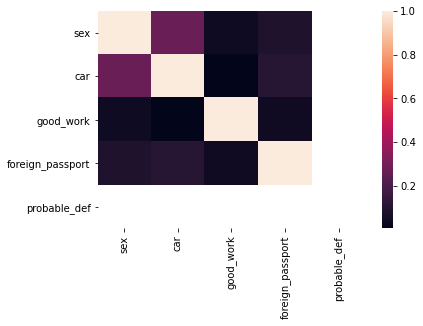

In [313]:
sns.heatmap(banking[bin_cols].corr().abs())

# Categorial

In [314]:
cat_cols = ['education', 'home_address', 'sna', 'first_time']

In [282]:
#Need to change str to int - Use OneHotEncoder
X_cat_train = OneHotEncoder(sparse = False).fit_transform(banking[banking.train == 1][cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(banking[banking.train == 0][cat_cols].values)
#will use it later

AttributeError: 'DataFrame' object has no attribute 'train'

# Evaluate num_cols

In [316]:
imp_num = pd.Series(f_classif(banking[banking.train==1][num_cols], banking[banking.train==1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color = 'green')

AttributeError: 'DataFrame' object has no attribute 'train'

The greates impact on default is given by score_bki 

# Distribution

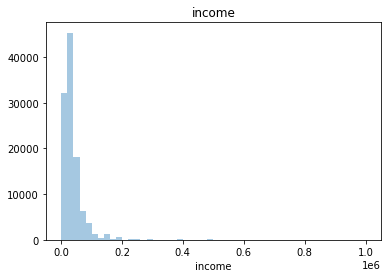

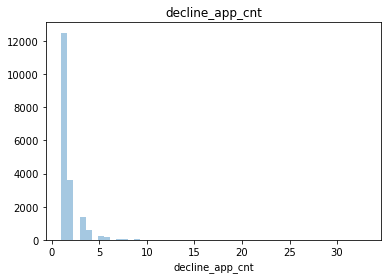

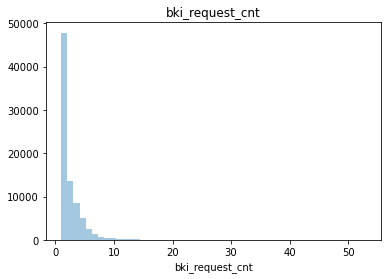

In [134]:
for i in ['income','decline_app_cnt','bki_request_cnt']:
    plt.figure()
    sns.distplot(banking[i][banking[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

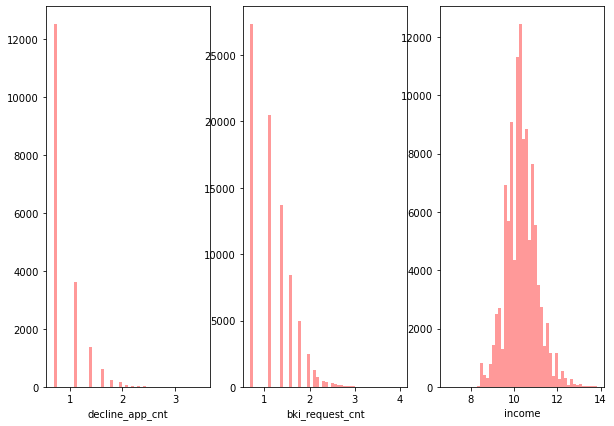

In [135]:
#Can be seen that values are strongly inclined to the left - trying log[log+1 to avoid mathematical error]
fig, axes = plt.subplots(1, 3, figsize=(10,7))
for i,col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    banking[col] = np.log(banking[col] + 1)
    sns.distplot(banking[col][banking[col] > 0].dropna(), ax=axes.flat[i],kde = False, rug=False,color="r")

age
decline_app_cnt
region_rating
score_bki
bki_request_cnt
income


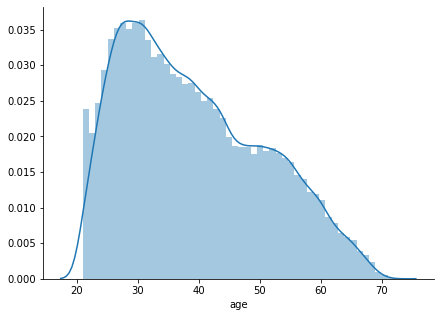

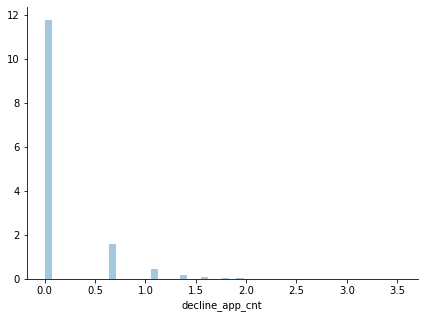

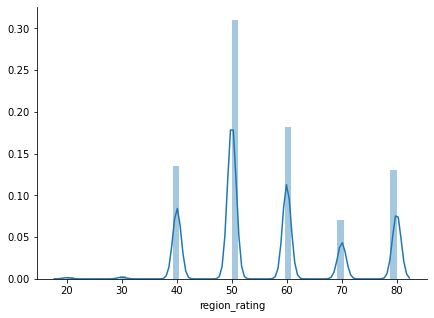

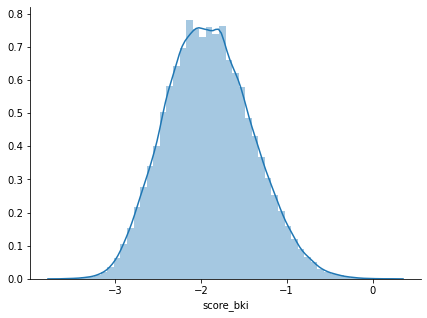

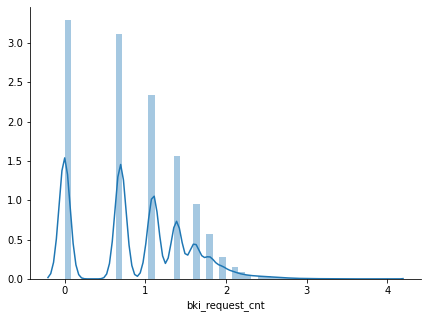

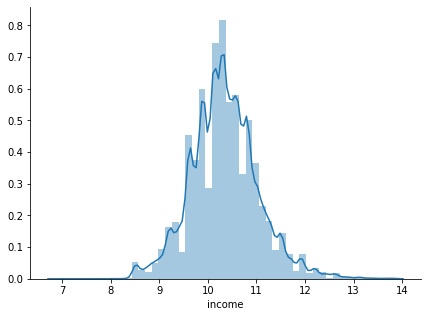

In [90]:
#Lets analyze numerical columns more thoroughly
for col in num_cols:
    print(col)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)
    sns.distplot(
    banking[col])

age


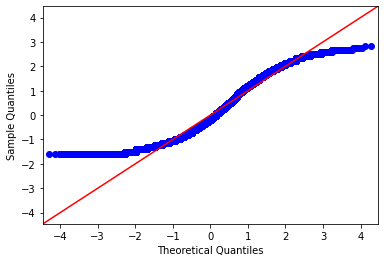

decline_app_cnt


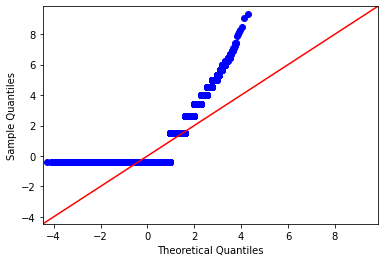

region_rating


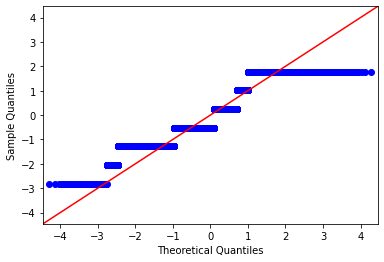

score_bki


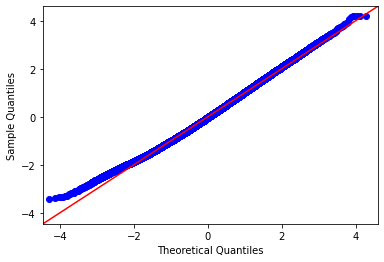

bki_request_cnt


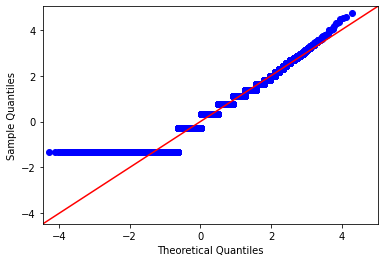

income


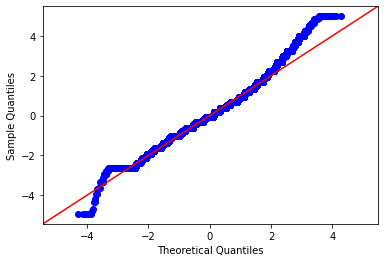

In [91]:
#use qq to determine whether the distribution is eneven
import statsmodels.api as sm
import pylab
for col in num_cols:
    print(col)
    sm.qqplot(banking[col], line='45',fit = True)
    pylab.show()

age


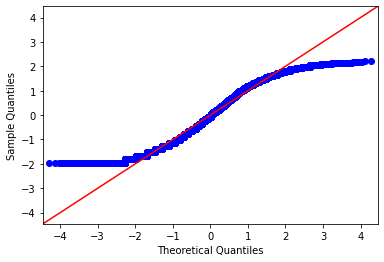

decline_app_cnt


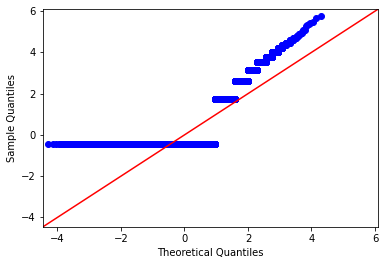

bki_request_cnt


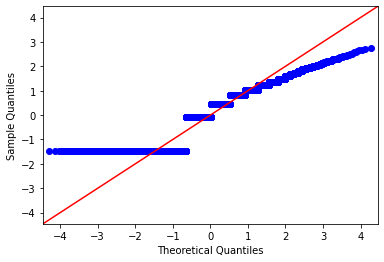

income


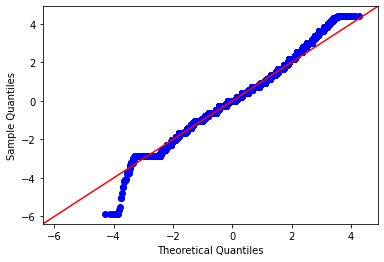

In [92]:
quest_cols = ['age','decline_app_cnt','bki_request_cnt','income']
for col in quest_cols:
    print(col)
    sm.qqplot((banking[col]+1).transform(np.log), line='45',fit = True)
    pylab.show()

age
decline_app_cnt
region_rating
score_bki
bki_request_cnt
income


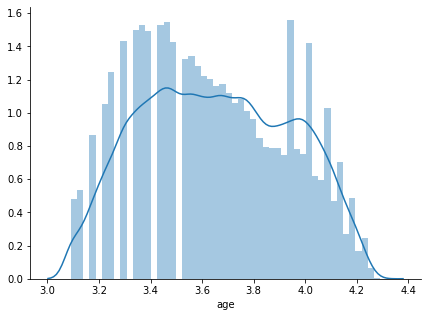

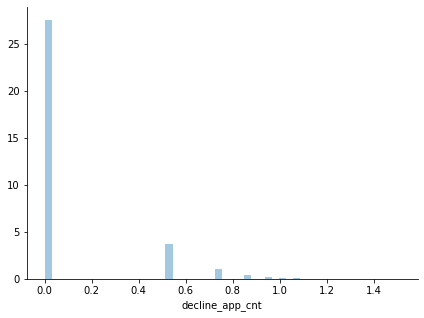

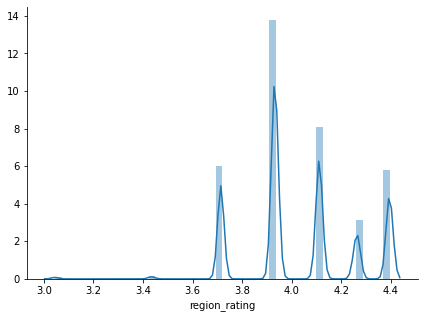

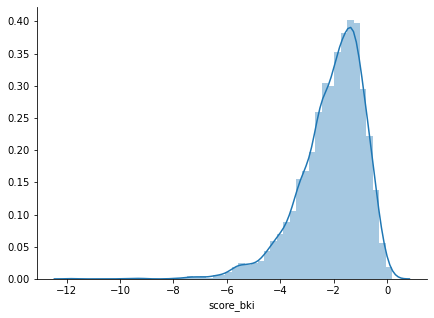

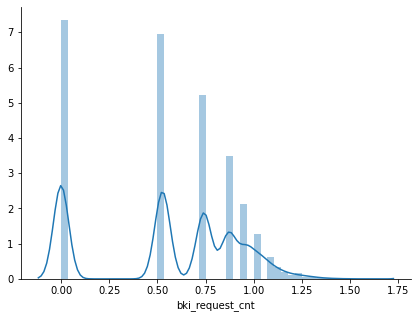

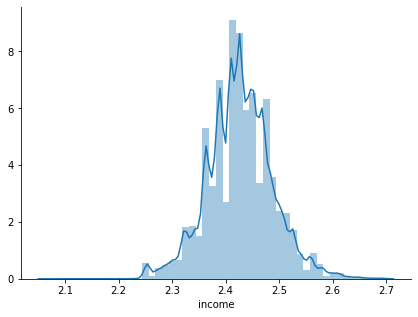

In [93]:
for col in num_cols:
    print(col)
    f, ax = plt.subplots(figsize=(7, 5))
    sns.despine(f)
    sns.distplot(
    (banking[col]+1).transform(np.log))

In [317]:
#per graphs, we should apply log to age, decline_app_cnt,income
log_cols = ['age','decline_app_cnt','income']
for col in log_cols:
    banking[col] = (banking[col]+1).transform(np.log)

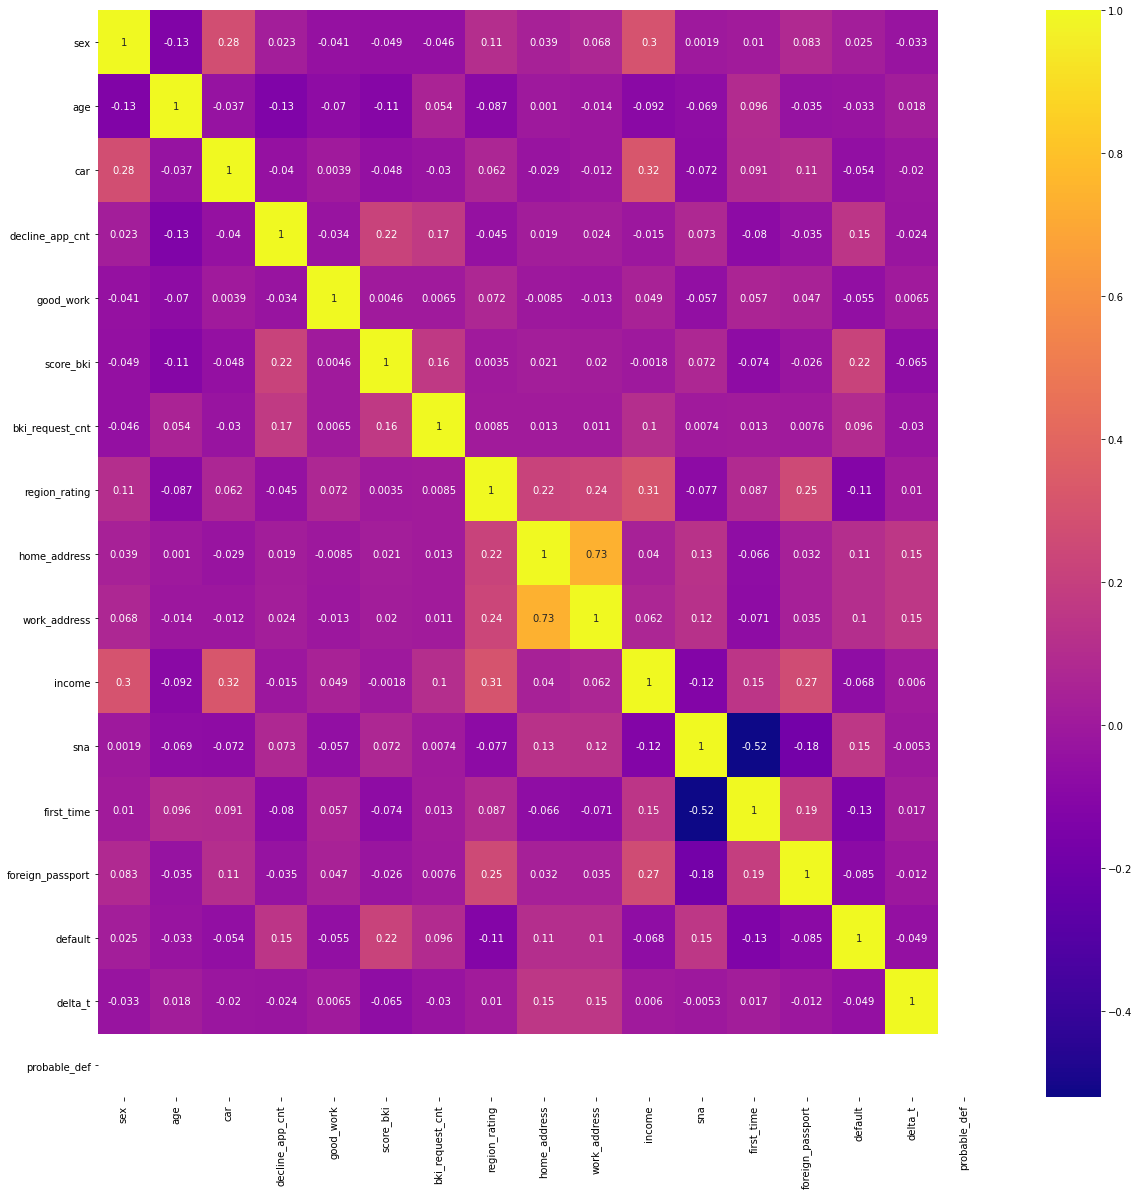

In [318]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(banking.corr(),annot = True, cmap = 'plasma')

In [287]:
#plot boxplots for every subject

KeyError: 'train'

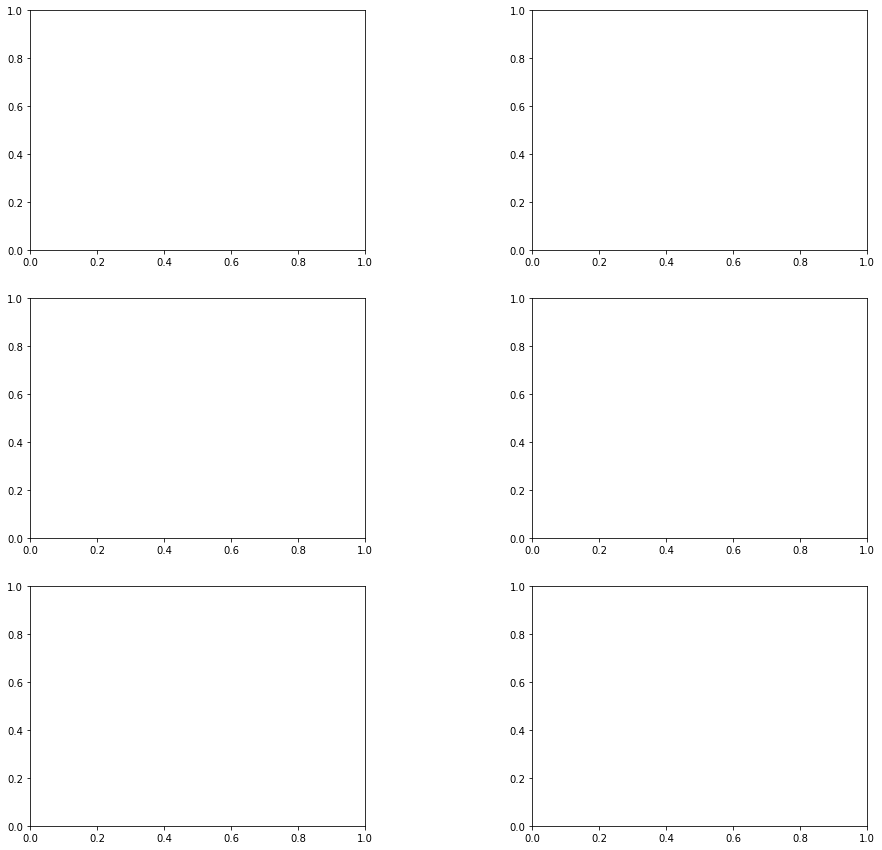

In [288]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data = banking[banking['train'] == 1], orient = 'v', ax=axes[i])

In [229]:
#Robust scaler may count low quantities of default as outliers
scaler = StandardScaler()
X_num_train = scaler.fit_transform(banking[banking.train ==1][num_cols].values)
X_num_test = scaler.fit_transform(banking[banking.train ==0][num_cols].values)

# LogisticRegression

In [230]:
train = banking[banking['train'] == 1]
test = banking[banking['train'] == 0]
X = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [231]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
# Добавим типы регуляризации
penalty = ['l1', 'l2']
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
# View best hyperparameters
c = best_model.best_estimator_.get_params()['C']
penalty = best_model.best_estimator_.get_params()['penalty']
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


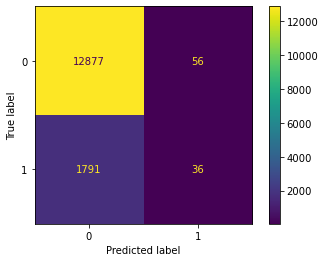

In [242]:
model = LogisticRegression(C=c, penalty=penalty, max_iter = 10000)
model.fit(X_train, y_train)
plot_confusion_matrix(model, X_test, y_test)  
plt.show() 

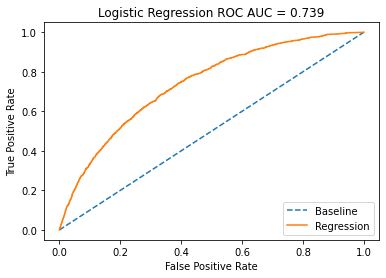

In [243]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [244]:
#Lets try class_weight == 'balanced'

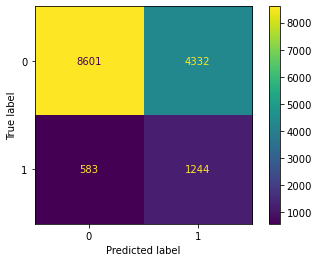

In [253]:
model = LogisticRegression(C=c, penalty=penalty, class_weight = 'balanced', max_iter = 1000)
model.fit(X_train, y_train)
plot_confusion_matrix(model, X_test, y_test)  
plt.show() 

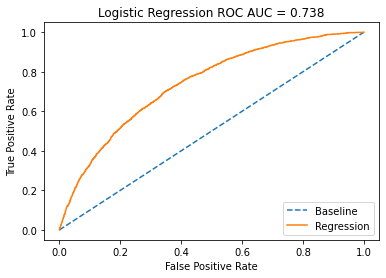

In [254]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [257]:
print('accuracy_score:',accuracy_score(y_test, model.predict(X_test)))
print('precision_score:',precision_score(y_test, model.predict(X_test)))
print('recall_score:',recall_score(y_test, model.predict(X_test)))
print('f1_score:',f1_score(y_test, model.predict(X_test)))

accuracy_score: 0.6670054200542005
precision_score: 0.22309899569583932
recall_score: 0.6808976464148878
f1_score: 0.3360799675807105


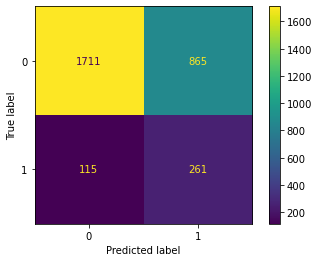

In [247]:
#Check on test part
X_t = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
y_t = test['default'].values
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_test, y_test, test_size=0.2, random_state=23, shuffle=True)
model = LogisticRegression(C=c, penalty=penalty, class_weight = 'balanced')
model.fit(X_t_train, y_t_train)
plot_confusion_matrix(model, X_t_test, y_t_test)  
plt.show() 

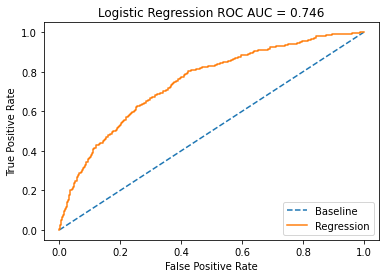

In [248]:
probs_t = model.predict_proba(X_t_test)
probs_t = probs_t[:,1]


fpr, tpr, threshold = roc_curve(y_t_test, probs_t)
roc_auc = roc_auc_score(y_t_test, probs_t)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Publishing 

In [239]:
train = banking[banking['train'] == 1]
test = banking[banking['train'] == 0]

X = np.hstack([X_num_train, train[bin_cols].values, X_cat_train])
y = train['default'].values

In [240]:
model = LogisticRegression(C=c, penalty=penalty, class_weight = 'balanced')
model.fit(X, y)

LogisticRegression(C=2.7825594022071245, class_weight='balanced')

In [202]:
x_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])

In [203]:
y_pred = model.predict_proba(x_test)

In [204]:
y_pred

array([[0.77784292, 0.22215708],
       [0.24778833, 0.75221167],
       [0.64939031, 0.35060969],
       ...,
       [0.19925764, 0.80074236],
       [0.41460536, 0.58539464],
       [0.28491205, 0.71508795]])

In [205]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [206]:
results_df = pd.DataFrame(data = {'client_id':test['client_id'], 'default':y_pred[:,1]})

In [207]:
results_df.to_csv('D_submission.csv', index=False)

In [208]:
results_df

client_id   default
0          74835  0.222157
1          17527  0.752212
2          75683  0.350610
3          26883  0.379563
4          28862  0.136507
...          ...       ...
36344      83775  0.794014
36345     106254  0.117564
36346      81852  0.800742
36347       1971  0.585395
36348      69044  0.715088

[36349 rows x 2 columns]

In [294]:
#Let's try oversampling. Do not concate test and train as it becomes complicated

In [295]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [296]:
banking_1 = train.query('default == 0')
banking_2 = train.query('default == 1')
ratio = int(len(banking_1)/len(banking_2))
for i in range(ratio):
    banking = train.append(banking_2).reset_index(drop=True)

In [297]:
banking

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0          25905  01FEB2014       SCH   M   62   Y        Y                0   
1          63161  12MAR2014       SCH   F   59   N        N                0   
2          25887  01FEB2014       SCH   M   25   Y        N                2   
3          16222  23JAN2014       SCH   F   53   N        N                0   
4         101655  18APR2014       GRD   M   48   N        N                0   
...          ...        ...       ...  ..  ...  ..      ...              ...   
83166      66804  15MAR2014       UGR   M   35   N        N                0   
83167       5312  12JAN2014       SCH   F   41   N        N                0   
83168      67970  17MAR2014       SCH   M   42   Y        Y                0   
83169      41091  17FEB2014       GRD   F   51   N        N                0   
83170        861  04JAN2014       SCH   F   29   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0              0  -2.008753                1             50             1   
1              0  -1.532276                3             50             2   
2              0  -1.408142                1             80             1   
3              0  -2.057471                2             50             2   
4              1  -1.244723                1             60             2   
...          ...        ...              ...            ...           ...   
83166          0  -1.645473                4             40             2   
83167          0  -1.198276                3             60             1   
83168          0  -1.653235                3             70             2   
83169          0  -1.259001                4             30             2   
83170          1  -1.479334                3             50             1   

       work_address  income  sna  first_time foreign_passport  default  
0                 2   18000    4           1                N        0  
1                 3   19000    4           1                N        0  
2                 2   30000    1           4                Y        0  
3                 3   10000    1           3                N        0  
4                 3   30000    1           4                Y        0  
...             ...     ...  ...         ...              ...      ...  
83166             3   25000    4           3                N        1  
83167             1   25000    1           3                N        1  
83168             3   50000    4           4                N        1  
83169             3   15000    1           3                N        1  
83170             3   13000    2           3                N        1  

[83171 rows x 19 columns]

In [315]:
#Need to change str to int - Use OneHotEncoder
X_cat_train = OneHotEncoder(sparse = False).fit_transform(banking[cat_cols].values)

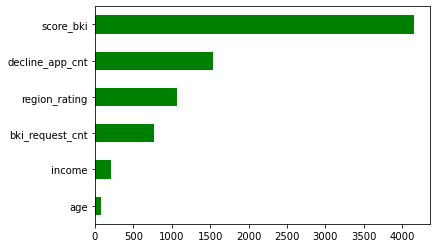

In [284]:
imp_num = pd.Series(f_classif(banking[num_cols], banking['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color = 'green')

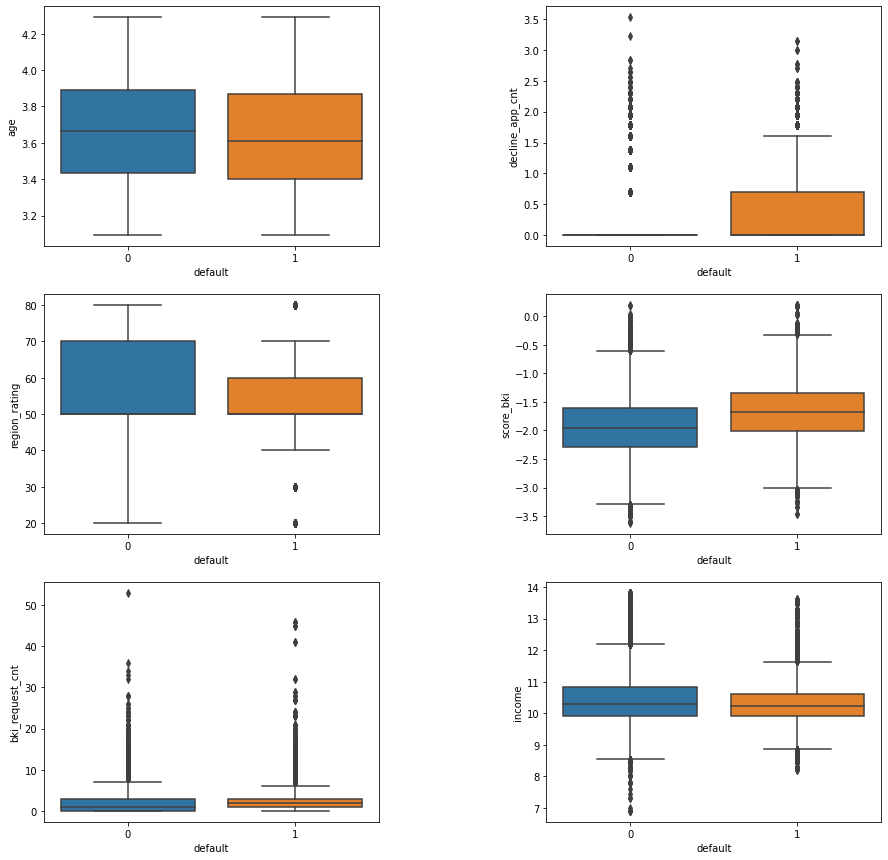

In [289]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data = banking, orient = 'v', ax=axes[i])

In [319]:
#Robust scaler may count low quantities of default as outliers
scaler = StandardScaler()
X_num_train = scaler.fit_transform(banking[num_cols].values)

In [321]:
X = np.hstack([X_num_train, banking[bin_cols].values, X_cat_train])
y = banking['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
# Добавим типы регуляризации
penalty = ['l1', 'l2']
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
# View best hyperparameters
c = best_model.best_estimator_.get_params()['C']
penalty = best_model.best_estimator_.get_params()['penalty']
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])